In [10]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [11]:
# Pre-processing: normalizing 0-mean, 1-std/var
def normalize(X):

    # scale = 255. - mean or std or sqrt(var) 
    # 255 == 2**8 or 8 bit grayscale
    X_norm = (X - X.mean(axis=0)) #/ X.std(axis=0)
    
    return X_norm

X_train, X_val, X_test = normalize(X_train), normalize(X_val), normalize(X_test)
X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [21]:
# Model
import impl.layer as l
from impl.loss import * # import all! 
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of hidden layer
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        self.model = [] # feedforward parameters: learnable
        self.W_fixed = [] # feedback weights: fixed
        
        # Input layer
        m = dict(W=np.random.uniform(size=(D, H), low=0.0, high=1.0) / D, b=np.zeros((1, H)))
        self.model.append(m) # self.model[0]
        W = np.random.uniform(size=(D, H), low=0.0, high=1.0) / H # W.T is used as feedback
        self.W_fixed.append(W) #self.W_fixed[0]

        # Hidden layers
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=0.0, high=1.0) / H, b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L) # self.model[1][L]
        W_L = []
        for _ in range(L):
            W = np.random.uniform(size=(H, H), low=0.0, high=1.0)/ H # W.T is used as feedback
            W_L.append(W)
        self.W_fixed.append(W_L) # self.W_fixed[1][L]
        
        # Output layer
        m = dict(W=np.random.uniform(size=(H, C), low=0.0, high=1.0) / H, b=np.zeros((1, C)))
        self.model.append(m) # self.model[2]
        W = np.random.uniform(size=(H, C), low=0.0, high=1.0) / C # W.T is used as feedback
        self.W_fixed.append(W) # self.W_fixed[2]
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache
        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment/ Bioprop

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y = l.sigmoid(X=y)
        X = y.copy() # pass the previous output to the next layer as the input
        caches.append(fc_cache) # caches[0]
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y = l.sigmoid(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
        caches.append(fc_caches) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included due to entropy for classification
        dy = dcross_entropy(y, y_train) # dsoftmax is included due to entropy for classification
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []
        
        # Output layer: first layer in feedback vs last layer in feedforward
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
#         dX = l.sigmoid(X=dX)
        dy = dX.copy() # pass it to the previous layer
        grads.append((dW, db)) # grads[0] vs model[2]

        # Hidden layer: middles layers in feedback vs middle layers in feedforward
        fc_caches = caches[1]
        grads_L = []
        for layer in reversed(range(self.L)):
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
#             dX = l.sigmoid(X=dX)
            dy = dX.copy()
            grads_L.append((dW, db))
        grads.append(grads_L) # grads[1][L] vs model[1][reversed(L)]
        
        # Input layer: last layer in feedback vs first layer in feedforward
        fc_cache = caches[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads.append((dW, db)) # grads[2] vs model[0]

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set
 
        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            dW, db = grads[2] # last layer for feedback vs first layer for feedforward
            self.model[0]['W'] -= alpha * dW
            self.model[0]['b'] -= alpha * db

            # Update the model for the hidden layers
            for layer in range(self.L): # last layer: self.L-1
                dW, db = grads[1][(self.L-1)-layer] # middle layer for feedback vs middle layer for feedforward
                self.model[1][layer]['W'] -= alpha * dW
                self.model[1][layer]['b'] -= alpha * db

            # Update the model for output layer
            dW, db = grads[0] # first layer for feedback vs last layer for feedforward
            self.model[2]['W'] -= alpha * dW
            self.model[2]['b'] -= alpha * db

            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax included
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [23]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.3033 valid loss: 2.3034, valid accuracy: 0.0986
Iter-20 train loss: 2.3053 valid loss: 2.3033, valid accuracy: 0.0986
Iter-30 train loss: 2.3042 valid loss: 2.3032, valid accuracy: 0.0986
Iter-40 train loss: 2.3027 valid loss: 2.3032, valid accuracy: 0.0986
Iter-50 train loss: 2.3032 valid loss: 2.3031, valid accuracy: 0.0986
Iter-60 train loss: 2.2989 valid loss: 2.3031, valid accuracy: 0.0986
Iter-70 train loss: 2.3058 valid loss: 2.3030, valid accuracy: 0.0986
Iter-80 train loss: 2.3056 valid loss: 2.3030, valid accuracy: 0.0986
Iter-90 train loss: 2.3000 valid loss: 2.3029, valid accuracy: 0.0986
Iter-100 train loss: 2.3045 valid loss: 2.3028, valid accuracy: 0.0986
Iter-110 train loss: 2.3043 valid loss: 2.3028, valid accuracy: 0.0986
Iter-120 train loss: 2.3000 valid loss: 2.3028, valid accuracy: 0.0986
Iter-130 train loss: 2.3000 valid loss: 2.3027, valid accuracy: 0.0986
Iter-140 train loss: 2.3036 valid loss: 2.3027, valid accuracy: 0.0986
Iter-150 train 

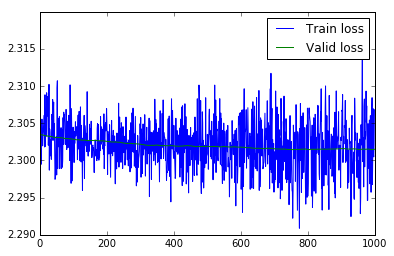

In [24]:
# Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

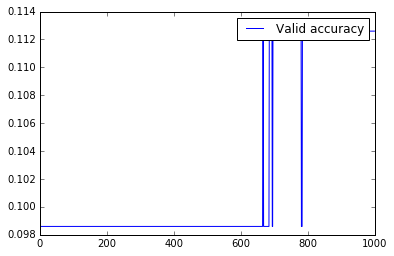

In [25]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()